In [1]:
# Byzantine Generals, N consensus using Qiskit, OOP Approach

# Import statements
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Patch
import qiskit_aer.noise as ns
from qiskit import QuantumCircuit, execute
from qiskit_aer import AerSimulator

#  Aesthetic Preferences
np.set_printoptions(edgeitems=30, linewidth=1000, formatter=dict(float=lambda x: "%.6g" % x))

# Importing IBM Nairobi Data Averages
ibm = pd.read_csv('ibm_nairobi_averages.csv')
# ibm = pd.read_csv('ibm_brisbane_averages.csv')
# ibm = pd.read_csv('ibm_guadalupe_averages.csv')


In [2]:
# Creating Classes for OOP Approach

class General():
    def __init__(self, general_number, is_commander=False):
        """
        An object that represents a single general, and tracks the associated attributes.
        id refers to their position in the list of generals.
        is_commander is a boolean that indicates whether the general is the commander, defaults to False.
        is_traitor is a boolean that indicates whether the general is a traitor, defaults to False.
        states 
        orders
        indices
        action
        """
        self.id = general_number
        self.is_commander = is_commander
        self.is_traitor = False
        # length of states will be the same for all generals, length of indices will be the same for all players
        self.states = None  # holds the measurement outcomes received
        self.orders = None  # holds the orders received from commander, or the opposite if general is a traitor
        self.indices = None  # holds the indices received from commander that correspond to self.orders
        self.records = []


    
    def __str__(self):
        # For user, only reveals attributes not None at initiation.
        return f"General Number:{self.id}, Is Commander:{self.is_commander}, Is Traitor:{self.is_traitor}\n"
        
    def __repr__(self):
        # For debugging, reveal all attributes, called when printing container of General objects e.g. generals_list
        return f"Num:{self.id}, Command:{self.is_commander}, Traitor:{self.is_traitor}, Orders:{self.orders}\n"
   
    def receive_orders(self, order, indices):
        self.orders = order
        self.indices = indices
        # lets only keep the indices that are not corrupted
        self.indices = self.indices[self.states[self.indices] != self.orders]
        if self.is_traitor and not self.is_commander:  # Only traitor lieutenants claim a different order
            self.indices = np.where(self.states == self.orders)[0][:len(self.indices)]  # Choosing the indices that will maximise deception success, but keeping the same number
            self.orders = not self.orders  # flipping the received order


class Byzantine_Network():
    def __init__(self, size):
        self.N_gen = size
        self.generals_list = []
        self.populate()
    
    def populate(self):
        if self.N_gen < 3:
            raise ValueError("Must have at least 2 generals in network.")
        self.generals_list.append(General(0, is_commander=True))
        for i in range(1,self.N_gen):
            self.generals_list.append(General(i, is_commander=False))


class Quantum_Source_Device():
    """
    This object represents the entanglement resource, it initializes and runs a quantum circuit. In theory the qubits should be distributed and measured by the generals.
    For the purposes of this model it is equivalent to measure centrally in this object and distribute measurement outcomes after.
    """
    def __init__(self, network_size, noise):
        self.network_size = network_size  # Number of generals
        self.noise = noise  # E_00, E_01, E_30, E_31 or between 0 and 1.33
        if isinstance(self.noise, float):  # Depolarizing quantum errors
            noise_model = ns.NoiseModel()
            error = ns.pauli_error([('X', noise), ('I', 1 - noise)])  # Bitflip error
            noise_model.add_all_qubit_quantum_error(error, "measure")  # Error occurs at point of measurement
            self.backend = AerSimulator(method='density_matrix', noise_model=noise_model)
        self.prepare_initial_state()
        self.circuit = QuantumCircuit(self.network_size+1)  # arg: number of qubits
    
    def prepare_initial_state(self):
        # Preparing the initial state as numpy array, values are amplitudes, called during QSD initialization
        state = np.zeros(2**(self.network_size+1))
        state[2**(self.network_size-1)-1] = np.sqrt(1/3)  # Retreat order from commander
        state[2**(self.network_size) + 2**(self.network_size-1)] = np.sqrt(1/3)  # Attack order from commander
        for i in range(self.network_size-1):
            state[2**(self.network_size-1) + 2**i] = np.sqrt(1/(6*self.network_size-6))  # commander '01'
            state[2**(self.network_size) + 2**(self.network_size-1) - 1 - 2**i] = np.sqrt(1/(6*self.network_size-6))  # commander '10'
        self.initial_state = state
        
    def run_circuit(self, shots):
        self.measurements = np.zeros((shots, self.network_size), dtype=int)  # Initializing array with a column for each general, and space to store the corresponding orders 0/1/2 retreat, attack, neither
        if isinstance(self.noise, float):
            self.circuit.initialize(self.initial_state, self.circuit.qubits)   # Initialize the qubits in the state to be distributed
            self.circuit.measure_active()  # Add a measurement of all qubits in the logical (0/1) basis
            job = execute(self.circuit, backend=self.backend, shots=shots, memory=True, optimization_level=3)
            memory = job.result().get_memory(self.circuit)  # record the strings of the measurement outcomes
        else:
            subset = ibm[ibm['N_Gen'] == self.network_size][['Value',self.noise]]
            memory = [val[1:] for val in np.random.choice(subset['Value'], size=shots, p=subset[self.noise])]
 
        # Converting into Array of corresponding orders
        com_dic = {'00':0, '01':2, '10':2, '11':1}  # convert bitstrings to ints and store them
        for i, bitstring in enumerate(memory):
            self.measurements[i][0] = com_dic[bitstring[0:2]] # Commander 2 indices
            for j in range(self.network_size-1):
                self.measurements[i][j+1] = int(bitstring[j+2])


class Quantum_Byzantine_Scheme():
    def __init__(self, size, shots, noise, batch, verbose):  # batch should be individual layer of batch matrix (no need to pass batch number)
        self.size = size
        self.shots = shots
        self.noise = noise
        self.batch = batch
        self.verbose = verbose
        self.network = Byzantine_Network(self.size)
        self.distribute_entanglement_resource()

    def flip_allegiance(self, *general_number):
        for val in general_number:
            self.network.generals_list[val].is_traitor = not self.network.generals_list[val].is_traitor
    
    def distribute_entanglement_resource(self):
        for general in self.network.generals_list:
            general.states = self.batch[:, general.id]

    def verify_entanglement(self):
        col_names = ['L'+str(val) for val in range(self.size)]
        col_names[0] = 'C'
        outcomes = [*itertools.product([0,1,2],*[[0,1]]*(self.size-1))]
        self.ref_dist = pd.DataFrame(outcomes, columns=col_names)
        count_dist = pd.DataFrame(self.batch[np.random.randint(len(self.batch), size=len(self.batch)//3),:], columns=col_names).value_counts(normalize=False, sort=False).reset_index().rename(columns={0:'Count'})
        self.ref_dist = pd.merge(self.ref_dist, count_dist, on=col_names, how='outer').fillna(0)
        
    def send_orders(self, order=None):
        """When the commander is loyal, a random order is first selected, corresponding indices are chosen and the lieutentants receive the same indices.
        When the commander is a traitor, under rational agent assumptions, to minimize consensus half of the lieutentants receive one order (correct) and half receive the other.
        Along with the corresponding indices. This is acheived by randomly reassigning order."""
        l0, l1 = len(np.where(self.network.generals_list[0].states == 0)[0]), len(np.where(self.network.generals_list[0].states == 1)[0])  
        shorter_index_length = min(l0, l1)  # comparing lengths of indices to choose the shortest
        if order is None:
            order = bool(np.random.randint(2))  # random order to demonstrate symmetry

        if not self.network.generals_list[0].is_traitor:  # Loyal Commander Case
            indices = np.where(self.network.generals_list[0].states == order)[0][0:shorter_index_length]
            for gen in self.network.generals_list:
                gen.receive_orders(order, indices)
        else:
            for gen in self.network.generals_list:  # Traitor Commander Case
                indices = np.where(self.network.generals_list[0].states == order)[0][0:shorter_index_length]
                gen.receive_orders(order, indices)
                order = not order  # half will get one order and half the other

    def realize_agreement(self):
        def play(gen_pair):
            rounds = min([len(gen_pair[0].indices), len(gen_pair[1].indices)])  # Exchange the smaller number of indices
            if gen_pair[0].orders != gen_pair[1].orders:  # Check if they agree on the order then initiate game if they do not
                if not (gen_pair[0].is_traitor and gen_pair[1].is_traitor):  # Ignore cases with both traitors WLOG wrt DBA for speed
                    if not gen_pair[0].is_traitor:  # Only need to bother with records for loyal
                        # gen_pair[0] = Me, gen_pair[1] = You
                        # First getting actual Agree-Disagree
                        my_record = np.zeros((2,6))  # Columns: Commander Value, My Val, Your Val, Count, L Traitor, C Traitor
                        my_record[:,0] = gen_pair[1].orders  # Your claimed order
                        my_record[0,1:3] = gen_pair[0].orders  # Agreement row
                        my_record[1,1] = gen_pair[1].orders  # Disgreement row
                        my_record[1,2] = gen_pair[0].orders  # Disgreement row
                        my_record[0,3] = np.sum(gen_pair[0].states[gen_pair[1].indices[:rounds]] == gen_pair[0].orders)  # Agreement Count
                        my_record[1,3] = np.sum(gen_pair[0].states[gen_pair[1].indices[:rounds]] == gen_pair[1].orders)  # Disagreement Count
                        # Getting Expected A-D if L Traitor
                        my_expected = self.ref_dist[self.ref_dist['L'+str(gen_pair[1].id)] != my_record[0,0]]
                        exp_agreement = my_expected[my_expected['L'+str(gen_pair[0].id)] != my_record[0,0]]['Count'].sum()
                        exp_disagreement = my_expected[my_expected['L'+str(gen_pair[0].id)] == my_record[0,0]]['Count'].sum()
                        my_record[0,4] = exp_agreement
                        my_record[1,4] = exp_disagreement
                        # Getting Expected A-D if C Traitor
                        my_expected = self.ref_dist[(self.ref_dist['C'] == my_record[0,0]) & (self.ref_dist['L'+str(gen_pair[1].id)] != my_record[0,0])]
                        exp_agreement = my_expected[my_expected['L'+str(gen_pair[0].id)] != my_record[0,0]]['Count'].sum()
                        exp_disagreement = my_expected[my_expected['L'+str(gen_pair[0].id)] == my_record[0,0]]['Count'].sum()
                        my_record[0,5] = exp_agreement
                        my_record[1,5] = exp_disagreement
                        # Combining
                        gen_pair[0].records.append(my_record)

                    if not gen_pair[1].is_traitor:
                        your_record = np.zeros((2,6))  # Columns: Commander Value, My Val, Your Val, Count, L Traitor, C Traitor
                        your_record[:,0] = gen_pair[0].orders  # My claimed order
                        your_record[0,1:3] = gen_pair[1].orders  # Agreement row
                        your_record[1,2] = gen_pair[0].orders  # Disgreement row
                        your_record[1,1] = gen_pair[1].orders  # Disgreement row
                        your_record[0,3] = np.sum(gen_pair[1].states[gen_pair[0].indices[:rounds]] == gen_pair[1].orders)  # Agreement Count
                        your_record[1,3] = np.sum(gen_pair[1].states[gen_pair[0].indices[:rounds]] == gen_pair[0].orders)  # Disagreement Count
                        # Getting Expected A-D if L Traitor
                        your_expected = self.ref_dist[self.ref_dist['L'+str(gen_pair[0].id)] != your_record[0,0]]
                        exp_agreement = your_expected[your_expected['L'+str(gen_pair[1].id)] != your_record[0,0]]['Count'].sum()
                        exp_disagreement = your_expected[your_expected['L'+str(gen_pair[1].id)] == your_record[0,0]]['Count'].sum()
                        your_record[0,4] = exp_agreement
                        your_record[1,4] = exp_disagreement
                        # Getting Expected A-D if C Traitor
                        your_expected = self.ref_dist[(self.ref_dist['C'] == your_record[0,0]) & (self.ref_dist['L'+str(gen_pair[0].id)] != your_record[0,0])]
                        exp_agreement = your_expected[your_expected['L'+str(gen_pair[1].id)] != your_record[0,0]]['Count'].sum()
                        exp_disagreement = your_expected[your_expected['L'+str(gen_pair[1].id)] == your_record[0,0]]['Count'].sum()
                        your_record[0,5] = exp_agreement
                        your_record[1,5] = exp_disagreement
                        # Combining
                        gen_pair[1].records.append(your_record)

        pairs = list(itertools.combinations(self.network.generals_list[1:], 2))
        for pair in pairs:
            play(pair)

    def detectable_broadcast(self):
        loyal_gens = [gen for gen in self.network.generals_list[1:] if not gen.is_traitor]
        for gen in loyal_gens:
            if gen.orders and gen.records != []:  # Only need to potentially flip the generals who are loyal and received attack orders
                for record in gen.records:
                    # Getting Agreement Rates
                    actual = record[0,3]/(1+record[0,3]+record[1,3])
                    l_traitor = record[0,4]/(1+record[0,4]+record[1,4])
                    c_traitor = record[0,5]/(1+record[0,5]+record[1,5])
                    if self.verbose:
                        print(actual, l_traitor, c_traitor)

                    if np.abs(actual-l_traitor) > np.abs(actual-c_traitor):  # If closer to c traitor expectation then retreat
                        gen.orders = False

                
        tally = 0  # need to keep track of agreement
        db_achieved = False  # default false
        if not self.network.generals_list[0].is_traitor:  # If commander is loyal, all loyal generals agree on commanders action
            for gen in loyal_gens:
                tally += gen.orders == self.network.generals_list[0].orders
        else:  # If commander is traitor, then all loyal generals agree on common action
            for gen in loyal_gens:
                tally += gen.orders == loyal_gens[0].orders
        if tally == len(loyal_gens):
            db_achieved = True
        if self.verbose:
            for gen in self.network.generals_list:
                print(f"ID:{gen.id}, Traitor:{gen.is_traitor}, Orders:{gen.orders}")
        return db_achieved



def run_protocol(N_gen=5, N_traitors=1, shots=8192, noise=0.0, num_batches=1, verbose=False):
    master = Quantum_Source_Device(N_gen, noise)
    master.run_circuit(num_batches*shots)
    batched_measurements = np.reshape(master.measurements, (num_batches, shots, N_gen))
    dba = []
    for batch_num in range(num_batches):
        qbs = Quantum_Byzantine_Scheme(N_gen, shots, noise, batched_measurements[batch_num,:,:], verbose)
        qbs.verify_entanglement()
        qbs.flip_allegiance(*np.random.choice(N_gen, N_traitors, replace=False))
        qbs.send_orders()
        qbs.realize_agreement()
        dba.append(qbs.detectable_broadcast())
    return dba



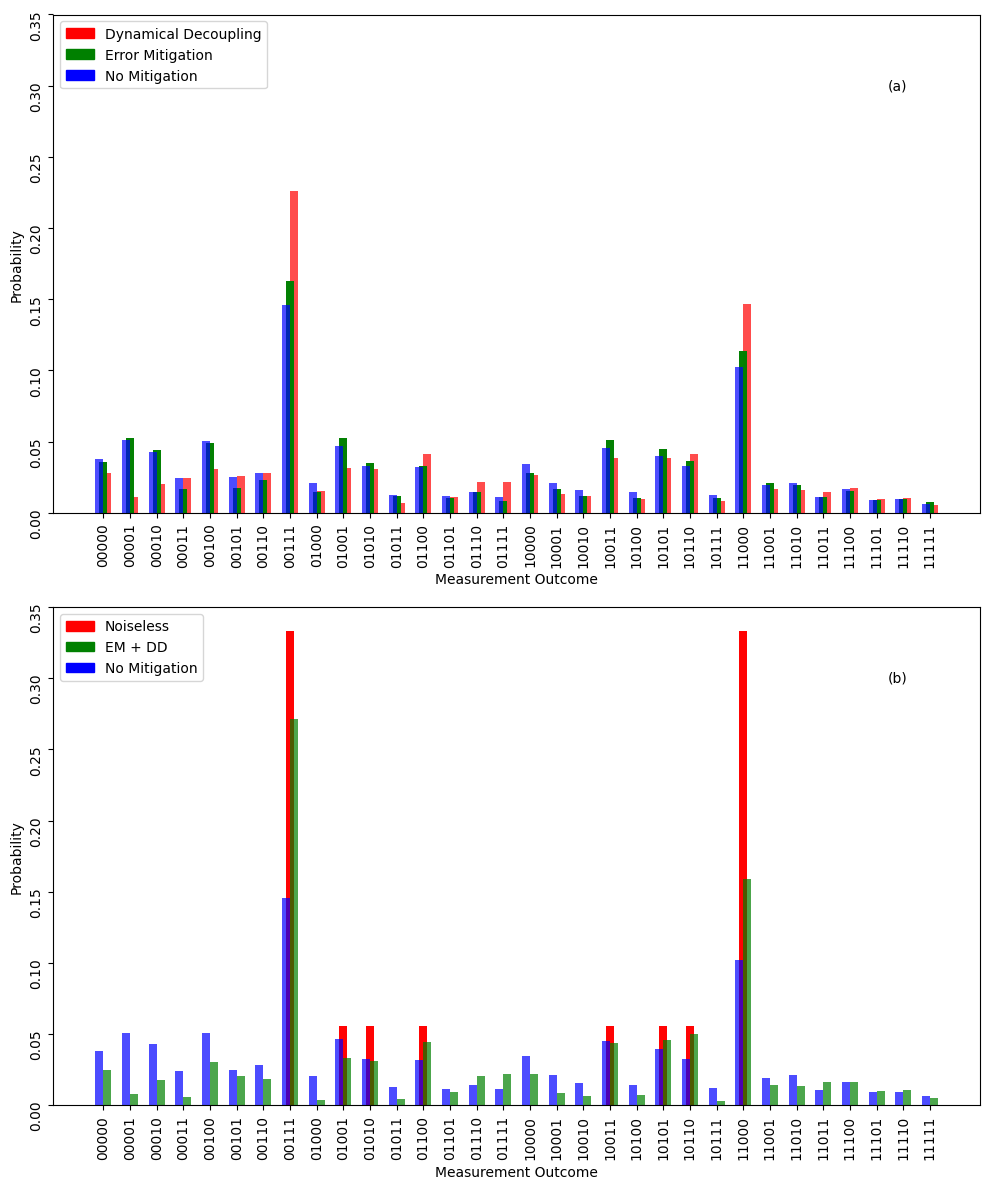

In [3]:
# IBM Data for 4 Generals
ngens = 4
df = ibm[ibm['N_Gen'] == ngens].reset_index()

# Adding in noiseless simulation results
qsd = Quantum_Source_Device(ngens, 0.0)
noiseless = [qp**2 for qp in qsd.initial_state]
df['Noiseless'] = noiseless
df['Value'] = df['Value'].str.replace('b','')
df.columns = ['index','N_Gen','Value','Raw','EM','DD','EM + DD','Noiseless']

# Initialise the subplot function using number of rows and columns 
wdt = 0.3
figure, axis = plt.subplots(2, 1, figsize=(10, 12)) 
dd = Patch(color='red', label='Dynamical Decoupling')
em = Patch(color='green', label='Error Mitigation')
no_noise = Patch(color='red', label='Noiseless')
em_dd = Patch(color='green', label='EM + DD')
nm = Patch(color='blue', label='No Mitigation')

axis[0].bar('Value', 'DD', data=df, width=wdt, align='edge', color='r', alpha=0.7)
axis[0].bar('Value', 'EM', data=df, width=wdt, align='center', color='g', alpha=0.99)
axis[0].bar('Value', 'Raw', data=df, width=-wdt, align='edge', color='b', alpha=0.7)
axis[0].legend(handles=[dd, em, nm], loc=2)
axis[0].set(ylabel='Probability', xlabel='Measurement Outcome', ylim=(0, 0.35))
axis[0].tick_params(labelrotation=90)
axis[0].annotate('(a)', xy=(0.9, 0.85), xycoords='axes fraction')


axis[1].bar('Value', 'Noiseless', data=df, width=wdt, align='center', color='r', alpha=0.99)
axis[1].bar('Value', 'EM + DD', data=df, width=wdt, align='edge', color='g', alpha=0.7)
axis[1].bar('Value', 'Raw', data=df, width=-wdt, align='edge', color='b', alpha=0.7)
axis[1].legend(handles=[no_noise, em_dd, nm], loc=2)
axis[1].set(ylabel='Probability', xlabel='Measurement Outcome', ylim=(0, 0.35))
axis[1].tick_params(labelrotation=90)
axis[1].annotate('(b)', xy=(0.9, 0.85), xycoords='axes fraction')

plt.tight_layout()
# plt.show()
plt.savefig('Figure 3.png', dpi=600)



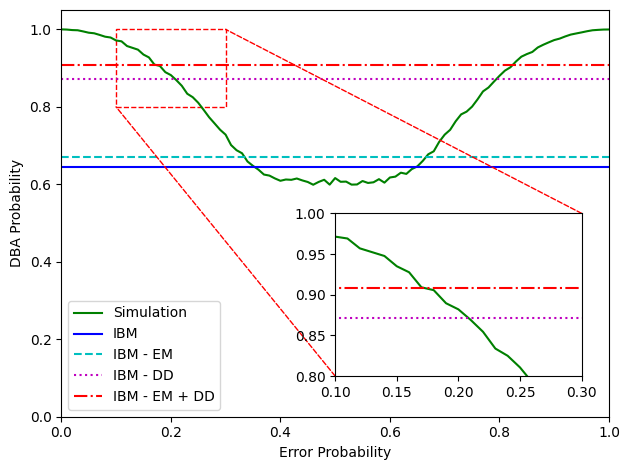

In [4]:

n_lvls = np.linspace(0.0, 1.0, 101)  # Range of Noise Levels to test
success = np.zeros(n_lvls.shape)  # Array to store success chances
iters = 10000

for i in range(len(n_lvls)):
    success[i] += sum(run_protocol(5, 1, shots=1000, noise=n_lvls[i], num_batches=iters, verbose=False))

E_00 = sum(run_protocol(5, 1, 1000, noise='E_00', num_batches=iters, verbose=False))/iters
E_01 = sum(run_protocol(5, 1, 1000, noise='E_01', num_batches=iters, verbose=False))/iters
E_30 = sum(run_protocol(5, 1, 1000, noise='E_30', num_batches=iters, verbose=False))/iters
E_31 = sum(run_protocol(5, 1, 1000, noise='E_31', num_batches=iters, verbose=False))/iters

ibm_res = np.zeros((4, len(n_lvls)))
ibm_res[0,:] = E_00
ibm_res[1,:] = E_01
ibm_res[2,:] = E_30
ibm_res[3,:] = E_31

# Create a figure and a main subplot (axes)
fig, ax = plt.subplots()

# Plot data on the main axes
ax.plot(n_lvls, success/iters, label='Simulation', color='g')
ax.plot(n_lvls, ibm_res[0,:], label='IBM', color='b', linestyle = '-')
ax.plot(n_lvls, ibm_res[1,:], label='IBM - EM', color='c', linestyle = '--')
ax.plot(n_lvls, ibm_res[2,:], label='IBM - DD', color='m', linestyle = 'dotted')
ax.plot(n_lvls, ibm_res[3,:], label='IBM - EM + DD', color='r', linestyle = '-.')

# Customize the plot
ax.set_xlabel('Error Probability')
ax.set_ylabel('DBA Probability')
ax.set_ylim(0, 1.05)
ax.set_xlim(0.0, 1.0)
ax.grid(False)

# coordinates of the region to zoom in
x1, x2, y1, y2 = 0.1, 0.3, 0.8, 1.0

# Create a rectangle to frame the interesting area in the main plot
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', ls="--")
ax.add_patch(rect)

# Create inset axes within the main plot axes
axins = ax.inset_axes([0.5, 0.1, 0.45, 0.4])  # Adjusted to 50% from the left, 5% from the bottom, and size 45% by 40% relative to the figure

axins.plot(n_lvls, success/iters, color='g')
axins.plot(n_lvls, ibm_res[2,:], color='m', linestyle = 'dotted')
axins.plot(n_lvls, ibm_res[3,:], color='r', linestyle = '-.')
axins.set_xlim(x1, x2)  # Apply the x-limits of the zoomed area
axins.set_ylim(y1, y2)  # Apply the y-limits of the zoomed area
axins.grid(False)

# Draw lines connecting the inset and the rectangle in the main plot
con1 = ConnectionPatch(xyA=(x1, y1), xyB=(x1, y1), coordsA="data", coordsB="data",
                    axesA=axins, axesB=ax, color="red", linestyle="--")
con2 = ConnectionPatch(xyA=(x2, y2), xyB=(x2, y2), coordsA="data", coordsB="data",
                    axesA=axins, axesB=ax, color="red", linestyle="--")
axins.add_artist(con1)
axins.add_artist(con2)

# Show the plot with the zoom-in inset
ax.legend(loc='lower left')
plt.tight_layout()
# plt.show()
plt.savefig('Figure 4.png', dpi=600)




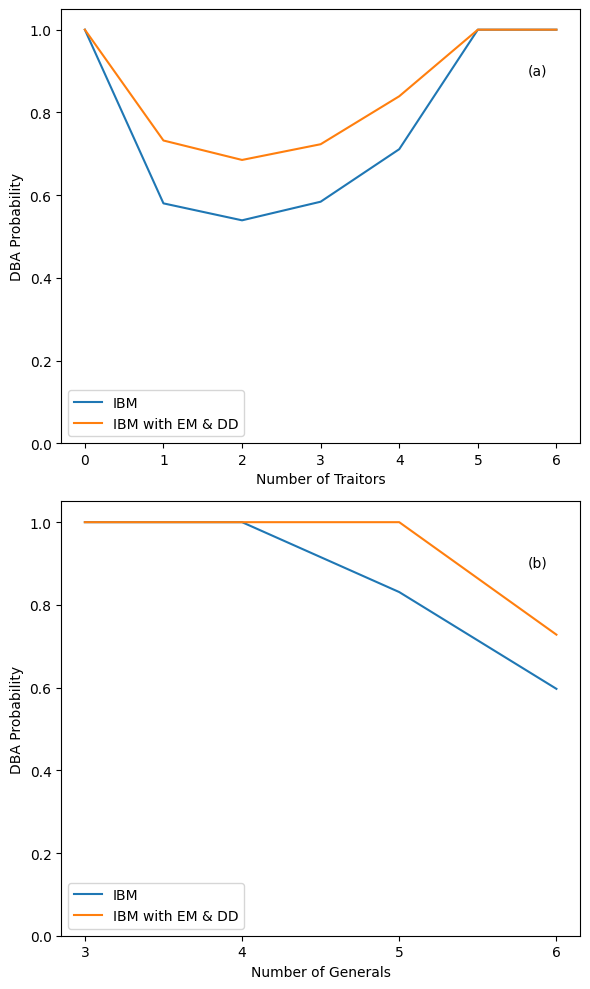

In [5]:
# DBA Probability with and without EM&DD with 6 generals by number of traitors
n_traitors = np.arange(0, 7, dtype='int')
# DBA Probability with and without EM&DD with 1 traitor by number of generals
n_gens = np.arange(3, 7, dtype='int')

success = np.zeros((len(n_traitors), 2, 2))  # Array to store success chances
iters = 1000

for i in range(len(n_traitors)):
    success[i,0,0] += sum(run_protocol(6, n_traitors[i], shots=10000, noise='E_00', num_batches=iters, verbose=False))
    success[i,0,1] += sum(run_protocol(6, n_traitors[i], shots=10000, noise='E_31', num_batches=iters, verbose=False))

for i in range(len(n_gens)):
    success[i,1,0] += sum(run_protocol(n_gens[i], 1, shots=10000, noise='E_00', num_batches=iters, verbose=False))
    success[i,1,1] += sum(run_protocol(n_gens[i], 1, shots=10000, noise='E_31', num_batches=iters, verbose=False))

# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(2, 1, figsize=(6, 10)) 

axis[0].plot(success[:,0,0]/iters, label='IBM') 
axis[0].plot(success[:,0,1]/iters, label='IBM with EM & DD')
axis[0].set(ylabel='DBA Probability', xlabel='Number of Traitors', ylim=(0, 1.05))
axis[0].legend(loc='lower left')
axis[0].annotate('(a)', xy=(0.9, 0.85), xycoords='axes fraction')

axis[1].plot(n_gens, success[:len(n_gens),1,0]/iters, label='IBM')
axis[1].plot(n_gens, success[:len(n_gens),1,1]/iters, label='IBM with EM & DD')
axis[1].set(ylabel='DBA Probability', xlabel='Number of Generals', ylim=(0, 1.05), xticks=n_gens)
axis[1].legend(loc='lower left')
axis[1].annotate('(b)', xy=(0.9, 0.85), xycoords='axes fraction')

plt.tight_layout()
# plt.show()
plt.savefig('Figure 5.png', dpi=600)



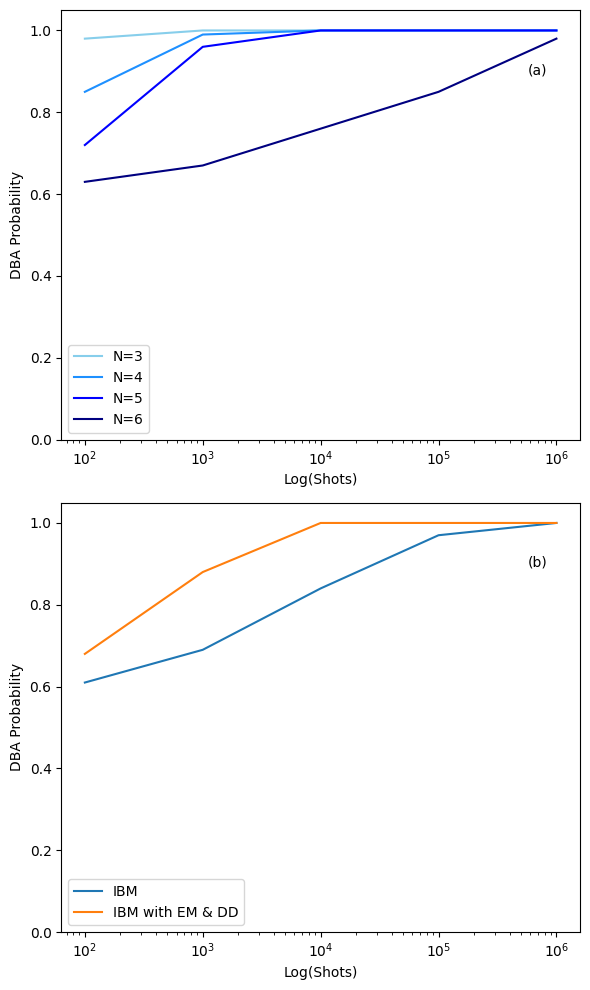

In [8]:
# DBA Probability with and without EM & DD by Shots
n_shots = np.array([10**val for val in range(2,7)], dtype='int')
iters = 100
gen_max = 6
success_a = np.zeros((len(n_shots)+1, gen_max))  # Array to store success chances
success_b = np.zeros((len(n_shots), 4))  # Array to store success chances

for i in range(len(n_shots)):
    for n_gen in range(3,gen_max+1):
        success_a[i,n_gen-3] += sum(run_protocol(n_gen, 1, shots=n_shots[i], noise='E_31', num_batches=iters, verbose=False))

for i in range(len(n_shots)):
    success_b[i,0] += sum(run_protocol(5, 1, shots=n_shots[i], noise='E_00', num_batches=iters, verbose=False))
    success_b[i,3] += sum(run_protocol(5, 1, shots=n_shots[i], noise='E_31', num_batches=iters, verbose=False))

# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(2, 1, figsize=(6, 10)) 

axis[0].plot(n_shots, success_a[:-1,0]/iters, label='N=3', color='skyblue')
axis[0].plot(n_shots, success_a[:-1,1]/iters, label='N=4', color='dodgerblue')
axis[0].plot(n_shots, success_a[:-1,2]/iters, label='N=5', color='blue')
axis[0].plot(n_shots, success_a[:-1,3]/iters, label='N=6', color='navy')
axis[0].set(ylabel='DBA Probability', xlabel='Log(Shots)', ylim=(0, 1.05), xscale="log")
axis[0].legend(loc='lower left')
axis[0].annotate('(a)', xy=(0.9, 0.85), xycoords='axes fraction')

axis[1].plot(n_shots, success_b[:,0]/iters, label='IBM')
axis[1].plot(n_shots, success_b[:,3]/iters, label='IBM with EM & DD')
axis[1].set(ylabel='DBA Probability', xlabel='Log(Shots)', ylim=(0, 1.05), xscale="log")
axis[1].legend(loc='lower left')
axis[1].annotate('(b)', xy=(0.9, 0.85), xycoords='axes fraction')

plt.tight_layout()
# plt.show()
plt.savefig('Figure 6.png', dpi=600)

